# 5003 Final Project codes

## Visualizing stock correlation by the minimum spanning tree 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import yfinance as yf
import seaborn as sns
import networkx as nx 
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.cluster import normalized_mutual_info_score

### 1. DJIA

#### 1.1 Cross-correlation

In [2]:
# function to scrape companies in DJIA

def get_DJIA_components():
    r = requests.get('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
    html_contents = r.text
    html_soup = BeautifulSoup(html_contents, 'html.parser')
    table = html_soup.find('table', {'class': 'wikitable sortable'})
    components = []
    for i in range(1,31):
        components.append(table.find_all('tr')[i].find_all('td')[1].text.strip())
    return components


# functions to deal with data

def get_distance_for_corr(x):
    return np.sqrt(2 * (1-x))


def log_transform(x):
    return np.log(x)


In [3]:
# functions to get MST

def cmp(key1, key2):
    return (key1, key2) if key1 < key2 else (key2, key1)


def find_parent(record, node):
    if record[node] != node:
        record[node] = find_parent(record, record[node])
    return record[node]


def naive_union(record, edge):
    u, v = find_parent(record, edge[0]), find_parent(record, edge[1])
    record[u] = v


def kruskal(graph):
    edge_dict = {}
    for node in graph.keys():
        edge_dict.update({cmp(node, k): v for k, v in graph[node].items()})
    sorted_edge = list(sorted(edge_dict.items(), key=lambda kv: kv[1]))
    tree = []
    connected_records = {key: key for key in graph.keys()}

    for edge_pair, _ in sorted_edge:
        if find_parent(connected_records, edge_pair[0]) != find_parent(connected_records, edge_pair[1]):
            tree.append(edge_pair)
            naive_union(connected_records, edge_pair)
    return tree

Get stocks' Adj close price data from 2017-07-07 to 2022-07-07

In [4]:
company_list = get_DJIA_components()
df = pd.DataFrame()
for company in company_list:
    data = yf.download(company, start="2017-07-07", end="2022-07-08")
    if len(data) == 1259:
        df[company] = data[['Adj Close']].values.ravel()
df.index = data.index

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
df_log = df.applymap(log_transform)
df_v2 = df_log.diff().dropna(how='any', axis=0)
# df_v2

corr = df_v2.corr()
D_matrix = corr.applymap(get_distance_for_corr)
# D_matrix

Get correlation heatmap

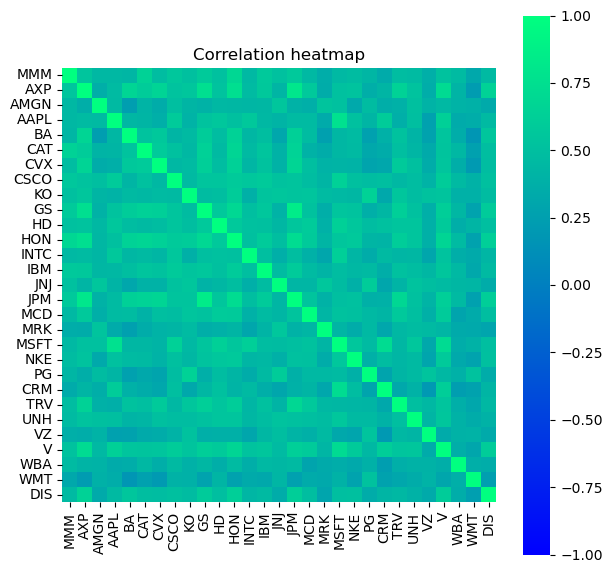

In [6]:
plt.figure(figsize=(7,7))
sns.heatmap(corr,cmap='winter', vmin=-1, vmax=1, annot=False, square=True) 
plt.title('Correlation heatmap')
plt.show()

Get MST

In [7]:
graph_dict = D_matrix.to_dict()
path = kruskal(graph_dict)

MST = {}
for pair in path:
    distance = graph_dict[pair[0]][pair[1]]
    MST[pair] = distance
MST

{('GS', 'JPM'): 0.5508230058436747,
 ('AXP', 'JPM'): 0.6188305005648529,
 ('AAPL', 'MSFT'): 0.6913423652243991,
 ('AXP', 'HON'): 0.7180272128766356,
 ('CRM', 'MSFT'): 0.7433814027973019,
 ('MSFT', 'V'): 0.7517583864295551,
 ('AXP', 'V'): 0.7576506844093114,
 ('HON', 'MMM'): 0.7941925387466483,
 ('JPM', 'TRV'): 0.7992011612274079,
 ('CAT', 'HON'): 0.8103318065202265,
 ('AXP', 'BA'): 0.8164692419044257,
 ('CVX', 'JPM'): 0.8195721330276066,
 ('AXP', 'DIS'): 0.8438422464551814,
 ('KO', 'PG'): 0.8456507684210688,
 ('CSCO', 'MSFT'): 0.8498879589382233,
 ('HD', 'MSFT'): 0.8653164211326215,
 ('INTC', 'MSFT'): 0.8700033971136129,
 ('HON', 'KO'): 0.8970525832540139,
 ('JNJ', 'PG'): 0.8971494181592378,
 ('MCD', 'V'): 0.901407306602213,
 ('IBM', 'JPM'): 0.9042348061440278,
 ('NKE', 'V'): 0.9150425035211653,
 ('JNJ', 'MRK'): 0.9390447280715768,
 ('MSFT', 'UNH'): 0.9393454249177083,
 ('AMGN', 'JNJ'): 0.9442141742179112,
 ('PG', 'VZ'): 0.9650473225175269,
 ('PG', 'WMT'): 0.979522778600106,
 ('MMM', '

The graph of MST

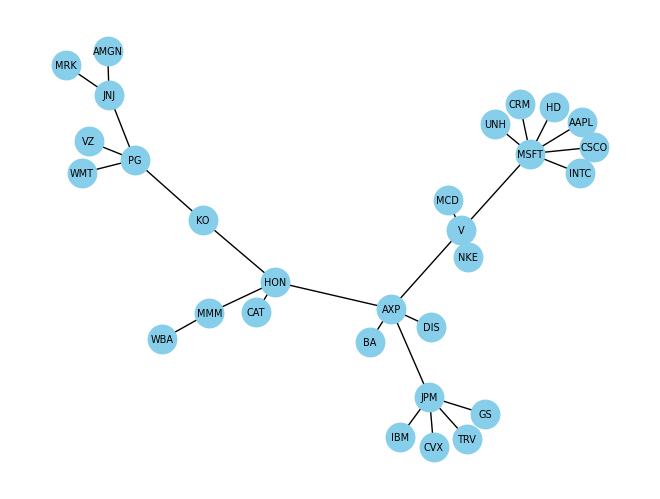

In [8]:
G = nx.Graph() 
G.add_edges_from(path)
nx.draw(G, with_labels=True, node_size=420, font_size=7, node_color='skyblue')
plt.show()

Get the subdominant ultrametric distance matrix $D^{<}$

In [9]:
# find path in MST

def findAllPath(graph, start ,end, path=[]):
    path = path + [start]
    if start == end:
        return path
 
    for node in graph[start]:
        if node not in path:
            newpaths = findAllPath(graph, node, end, path) 
            for newpath in newpaths:
                if newpath==end:
                    path.append(newpath)
                    paths.append(path)
    return paths

In [10]:
# get condensed distance matrix for hierarchical tree

dic_MST = nx.to_dict_of_dicts(G)
lis = list(D_matrix.columns)
condensed = []
for i in range(len(lis)-1):
    for j in range(i+1, len(lis)):
        paths = [] 
        path = findAllPath(dic_MST, lis[i], lis[j])[0]
        dis = []
        for k in range(len(path)-1):
            dis += [MST[(path[k], path[k+1])]] if (path[k], path[k+1]) in list(MST.keys()) else [MST[(path[k+1], path[k])]]
        condensed.append(np.max(dis))
        
condensed = np.array(condensed)

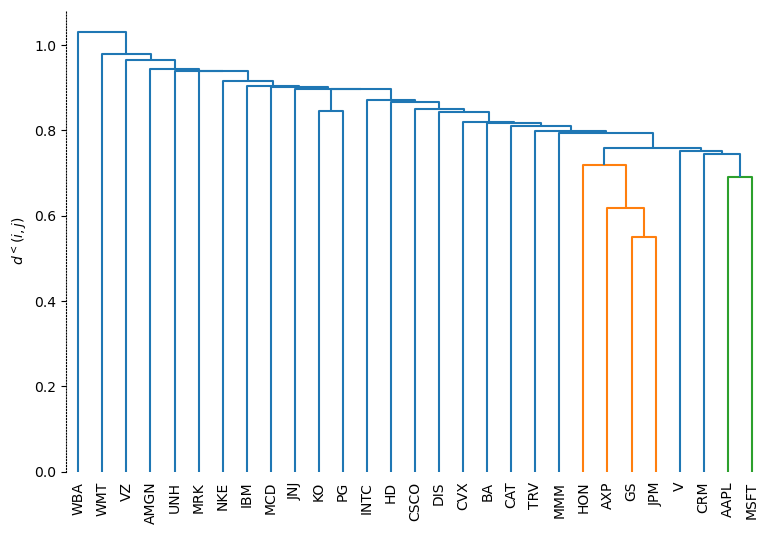

In [11]:
plt.figure(figsize=(9,6))
ax=plt.gca() 
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_linestyle(':')
plt.ylabel('$d^{<}(i,j)$')

linkage_matrix = linkage(condensed, method='complete')
dendrogram(linkage_matrix, labels=[i for i in D_matrix.columns], leaf_rotation=90)

plt.show()

#### 1.2 Mutual information

In [12]:
def encode_array(array, df_v2, n=2):
    interval = np.linspace(np.min(df_v2.min()), np.max(df_v2.max()), n+1)
    for i in range(len(interval)-1):
        array = np.where((array>=interval[i]) & (array<=interval[i+1]), i+1, array)
    return array


def get_MI_matrix(df_v2):
    df_v3 = pd.DataFrame()
    for item in df_v2.columns:
        data = encode_array(df_v2[[item]].values.ravel(), df_v2)
        df_v3[item] = data
    lis = list(df_v3.columns)
    MI = pd.DataFrame()
    for col in lis:
        mi = []
        for col2 in lis:
            element = normalized_mutual_info_score(df_v3[[col]].values.ravel(), df_v3[[col2]].values.ravel())
            if element > 1.0:
                element = 1
            mi.append(element)
        MI[col] = np.array(mi)
    MI.index = lis
    return MI

In [13]:
MI = get_MI_matrix(df_v2)
D_matrix_MI = MI.applymap(get_distance_for_corr)

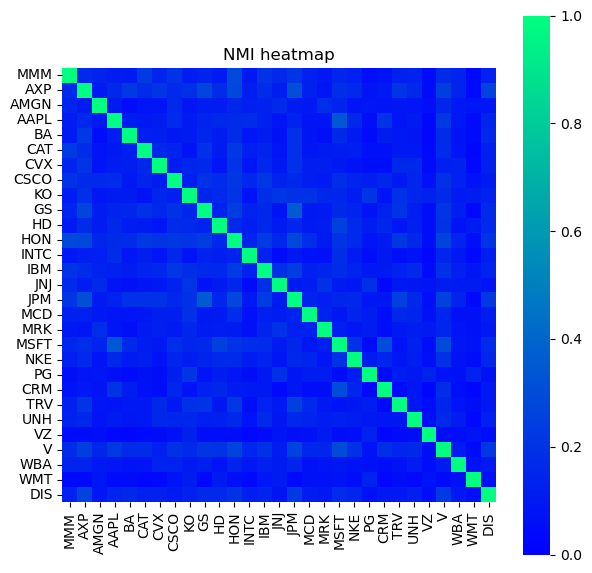

In [14]:
plt.figure(figsize=(7,7))
sns.heatmap(MI, cmap='winter',vmin=0, vmax=1, annot=False, square=True) 
plt.title('NMI heatmap')
plt.show()

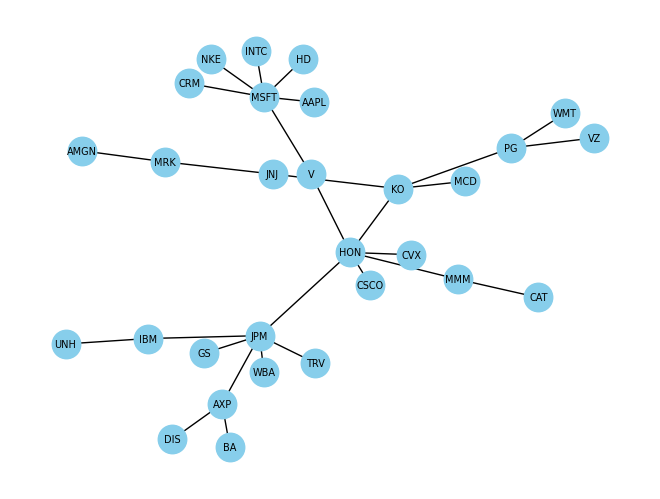

In [15]:
graph_dict = D_matrix_MI.to_dict()
path = kruskal(graph_dict)

MST = {}
for pair in path:
    distance = graph_dict[pair[0]][pair[1]]
    MST[pair] = distance

G = nx.Graph() 
G.add_edges_from(path)
nx.draw(G, with_labels=True, node_size=420, font_size=7, node_color='skyblue')
plt.show()

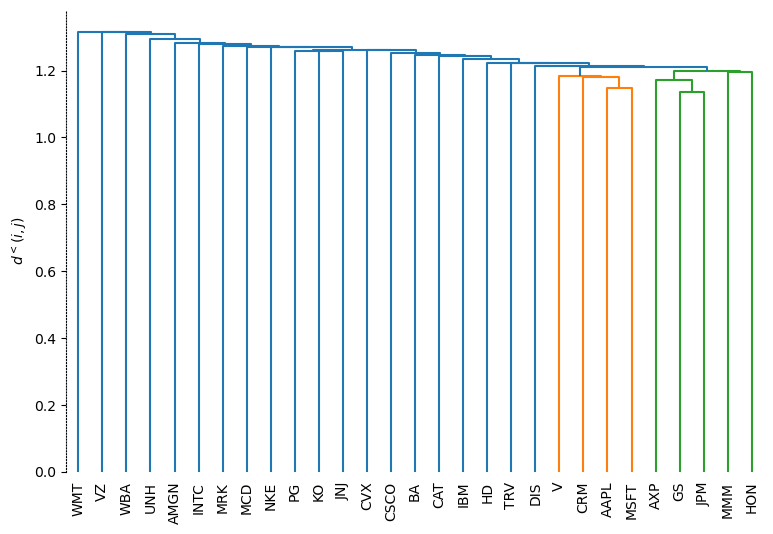

In [16]:
dic_MST = nx.to_dict_of_dicts(G)
lis = list(D_matrix_MI.columns)
condensed = []
for i in range(len(lis)-1):
    for j in range(i+1, len(lis)):
        paths = [] 
        path = findAllPath(dic_MST, lis[i], lis[j])[0]
        dis = []
        for k in range(len(path)-1):
            dis += [MST[(path[k], path[k+1])]] if (path[k], path[k+1]) in list(MST.keys()) else [MST[(path[k+1], path[k])]]
        condensed.append(np.max(dis))
        
condensed = np.array(condensed)

plt.figure(figsize=(9,6))
ax=plt.gca() 
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_linestyle(':')
plt.ylabel('$d^{<}(i,j)$')

linkage_matrix = linkage(condensed, method='complete')
dendrogram(linkage_matrix, labels=[i for i in D_matrix.columns], leaf_rotation=90, color_threshold=1.2)

plt.show()

### 2. NASDAQ 100 Index

#### 2.1 Cross-correlation

In [17]:
# function to scrape companies in NASDAQ

def get_NAS_components():
    r = requests.get('https://en.wikipedia.org/wiki/Nasdaq-100')
    html_contents = r.text
    html_soup = BeautifulSoup(html_contents, 'html.parser')
    table = html_soup.find_all('table', {'class': 'wikitable sortable'})[-1]
    components = []
    for i in range(1,len(table.find_all('tr'))):
        components.append(table.find_all('tr')[i].find_all('td')[1].text.strip())
    return components

In [18]:
# companies not appeared in whole selected period  
remove_list = ["AMD", "ALGN", "AEP", "ANSS", "ASML", "TEAM", "AZN", "CDNS", "CEG",
               "CPRT", "CRWD", "DDOG", "DXCM", "DOCU", "EXC", "FTNT", "HON", "KDP",
               "LCID", "LULU", "MRVL", "MTCH", "MRNA", "ODFL", "PANW", "PEP", "PDD", 
               "SGEN", "SPLK", "SNPS", "VRSN", "WDAY", "XEL", "ZM", "ZS"]
company_NAS = get_NAS_components()
for item in remove_list:
    company_NAS.remove(item)
    
df_NAS = pd.DataFrame()
for company in company_NAS:
    data = yf.download(company, start="2017-07-07", end="2022-07-08")
    if len(data) == 1259:
        df_NAS[company] = data[['Adj Close']].values.ravel()
df_NAS.index = data.index

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [19]:
df_NAS_log = df_NAS.applymap(log_transform)
df_NAS_v2 = df_NAS_log.diff().dropna(how='any', axis=0)
corr_NAS = df_NAS_v2.corr()
D_matrix_NAS = corr_NAS.applymap(get_distance_for_corr)
D_matrix_NAS

,ATVI,ADBE,ADP,GOOGL,GOOG,AMZN,AMGN,ADI,AAPL,AMAT,...,ROST,SIRI,SWKS,SBUX,TMUS,TSLA,TXN,VRSK,VRTX,WBA
ATVI,0.000000,1.023348,1.174825,1.055699,1.057214,1.070657,1.163481,1.142652,1.070109,1.134474,...,1.301066,1.227347,1.116171,1.231769,1.178201,1.225925,1.083482,1.166031,1.154641,1.276272
ADBE,1.023348,0.000000,0.940816,0.766847,0.769429,0.819333,1.074300,0.872017,0.813874,0.901388,...,1.128631,1.075789,0.912723,0.992613,1.023133,1.046779,0.863629,0.918346,1.032340,1.226491
ADP,1.174825,0.940816,0.000000,0.930781,0.935713,1.069207,1.003900,0.940204,0.942701,0.969773,...,0.991872,0.952724,0.986992,0.911023,0.997255,1.166725,0.911722,0.857517,1.095659,1.091216
GOOGL,1.055699,0.766847,0.930781,0.000000,0.110272,0.808096,1.068014,0.873411,0.790903,0.865298,...,1.059835,1.055393,0.884507,0.953848,1.008967,1.082680,0.857526,0.944896,1.044006,1.153175
GOOG,1.057214,0.769429,0.935713,0.110272,0.000000,0.802370,1.068807,0.882433,0.790564,0.875786,...,1.060903,1.053100,0.893962,0.950582,1.011224,1.083653,0.863934,0.946160,1.046649,1.153606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TSLA,1.225925,1.046779,1.166725,1.082680,1.083653,1.081586,1.244547,1.069541,1.035663,1.057685,...,1.158277,1.187168,1.060869,1.150452,1.198909,0.000000,1.108055,1.187261,1.226110,1.291741
TXN,1.083482,0.863629,0.911722,0.857526,0.863934,0.974335,1.015225,0.563777,0.846079,0.671300,...,1.077440,1.046429,0.679140,0.978771,1.036890,1.108055,0.000000,0.954533,1.072227,1.118462
VRSK,1.166031,0.918346,0.857517,0.944896,0.946160,1.034237,1.019609,0.976771,0.946702,1.034419,...,1.078354,1.047924,1.012913,0.958784,1.015826,1.187261,0.954533,0.000000,1.077194,1.174951
VRTX,1.154641,1.032340,1.095659,1.044006,1.046649,1.097949,0.990395,1.108865,1.061480,1.098466,...,1.236701,1.190869,1.098044,1.150130,1.117578,1.226110,1.072227,1.077194,0.000000,1.215289


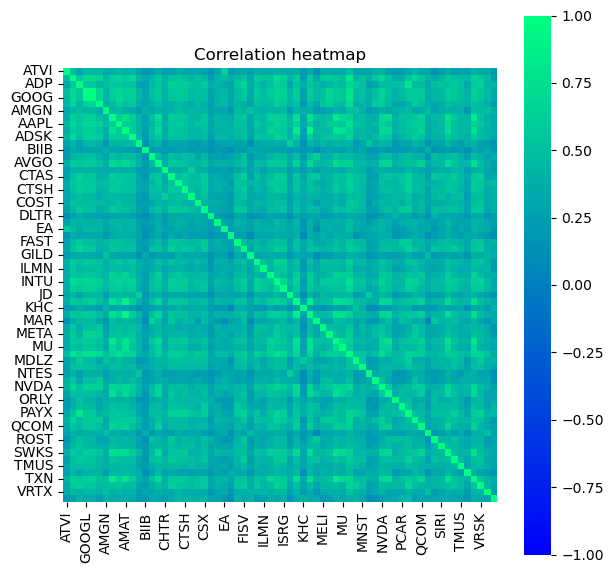

In [20]:
plt.figure(figsize=(7,7))
sns.heatmap(corr_NAS,cmap='winter', vmin=-1, vmax=1, annot=False, square=True) 
plt.title('Correlation heatmap')
plt.show()

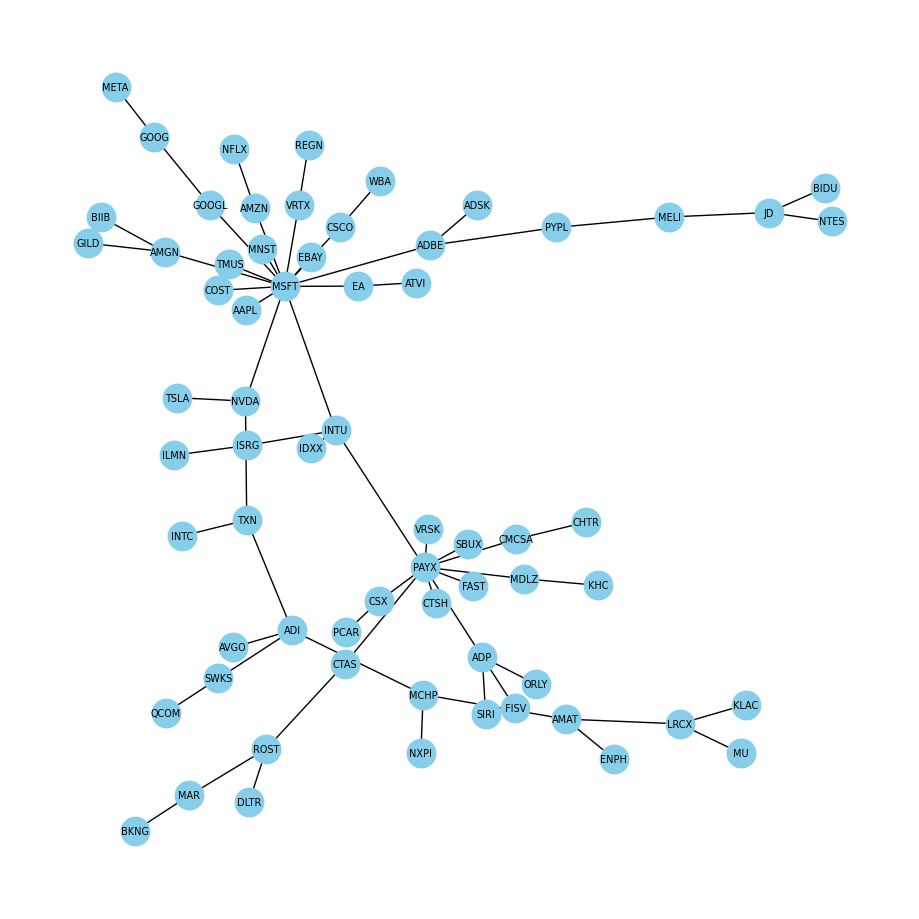

In [21]:
graph_dict = D_matrix_NAS.to_dict()
path = kruskal(graph_dict)

MST = {}
for pair in path:
    distance = graph_dict[pair[0]][pair[1]]
    MST[pair] = distance

plt.figure(figsize=(9,9))
G = nx.Graph() 
G.add_edges_from(path)
nx.draw(G, with_labels=True, node_size=420, font_size=7, node_color='skyblue')
plt.savefig('N-1-mst.png')
plt.show()

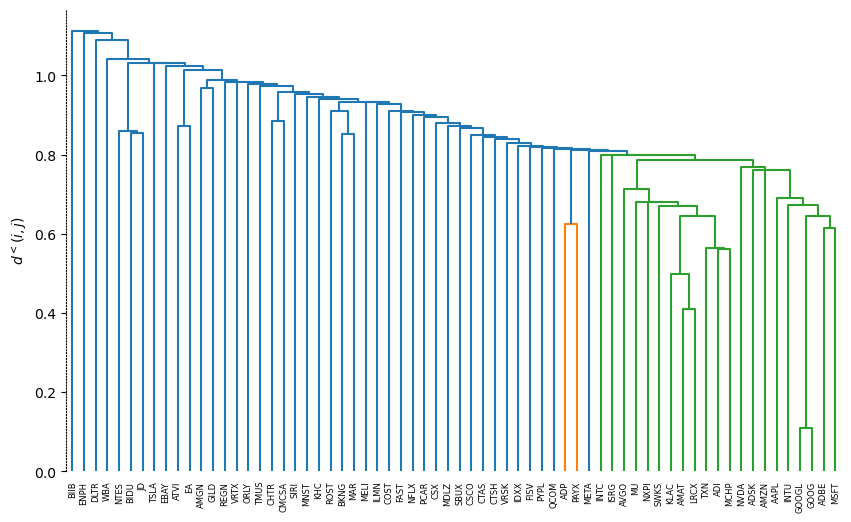

In [22]:
# get condensed distance matrix for hierarchical tree

dic_MST = nx.to_dict_of_dicts(G)
lis = list(D_matrix_NAS.columns)
condensed = []
for i in range(len(lis)-1):
    for j in range(i+1, len(lis)):
        paths = [] 
        path = findAllPath(dic_MST, lis[i], lis[j])[0]
        dis = []
        for k in range(len(path)-1):
            dis += [MST[(path[k], path[k+1])]] if (path[k], path[k+1]) in list(MST.keys()) else [MST[(path[k+1], path[k])]]
        condensed.append(np.max(dis))
        
condensed = np.array(condensed)

plt.figure(figsize=(10,6))
ax=plt.gca() 
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_linestyle(':')
plt.ylabel('$d^{<}(i,j)$')

linkage_matrix = linkage(condensed, method='complete')
dendrogram(linkage_matrix, labels=[i for i in D_matrix_NAS.columns], leaf_rotation=90, color_threshold=0.8)
plt.savefig('1.png', dpi=150)
plt.show()

#### 2.2 Mutual information

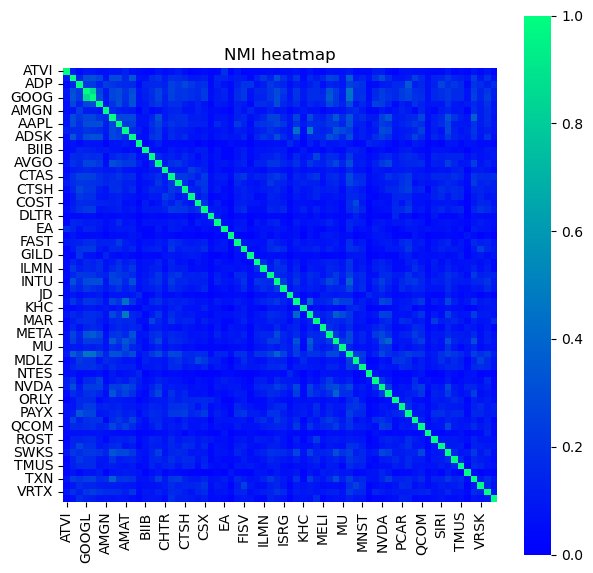

In [23]:
MI = get_MI_matrix(df_NAS_v2)
D_matrix_NAS_MI = MI.applymap(get_distance_for_corr)

plt.figure(figsize=(7,7))
sns.heatmap(MI,cmap='winter', vmin=0, vmax=1, annot=False, square=True) 
plt.title('NMI heatmap')
plt.show()

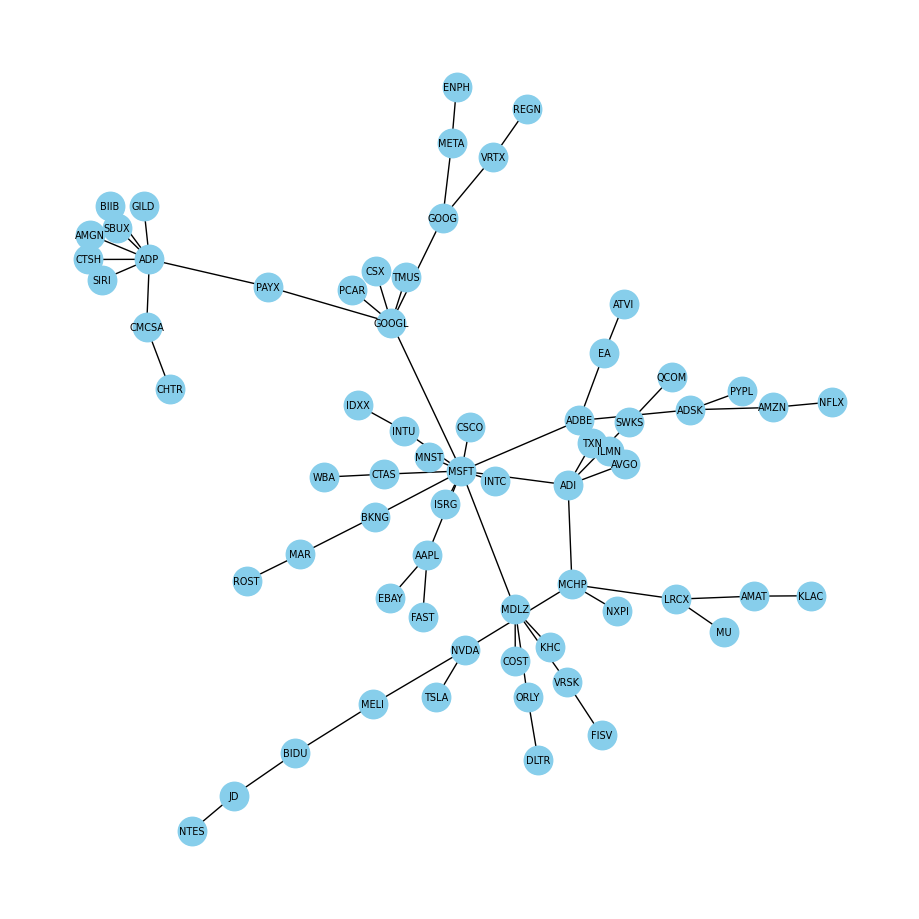

In [24]:
graph_dict = D_matrix_NAS_MI.to_dict()
path = kruskal(graph_dict)

MST = {}
for pair in path:
    distance = graph_dict[pair[0]][pair[1]]
    MST[pair] = distance

plt.figure(figsize=(9,9))
G = nx.Graph() 
G.add_edges_from(path)
nx.draw(G, with_labels=True, node_size=420, font_size=7, node_color='skyblue')
plt.savefig('Nmt.png')
plt.show()

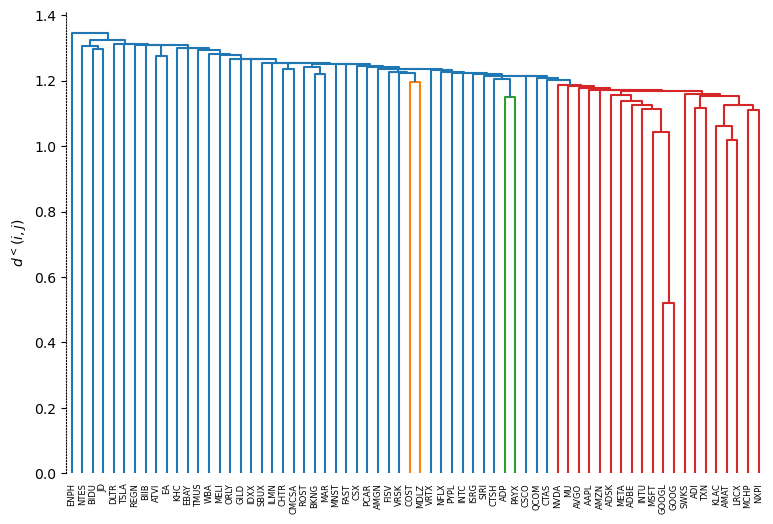

In [25]:
dic_MST = nx.to_dict_of_dicts(G)
lis = list(D_matrix_NAS_MI.columns)
condensed = []
for i in range(len(lis)-1):
    for j in range(i+1, len(lis)):
        paths = [] 
        path = findAllPath(dic_MST, lis[i], lis[j])[0]
        dis = []
        for k in range(len(path)-1):
            dis += [MST[(path[k], path[k+1])]] if (path[k], path[k+1]) in list(MST.keys()) else [MST[(path[k+1], path[k])]]
        condensed.append(np.max(dis))
        
condensed = np.array(condensed)

plt.figure(figsize=(9,6))
ax=plt.gca() 
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_linestyle(':')
plt.ylabel('$d^{<}(i,j)$')

linkage_matrix = linkage(condensed, method='complete')
dendrogram(linkage_matrix, labels=[i for i in D_matrix_NAS.columns], leaf_rotation=90, color_threshold=1.2)
plt.savefig('2.png', dpi=150)
plt.show()